# Unsupervised Learning - Cluster Modeling

In [1104]:
# Imports
import pandas as pd
import numpy as np
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import altair as alt
from vega_datasets import data

In [1105]:
# Select data
datasets = [
    "../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv",
    "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv",
]

OECD = False  # False for WB data
if OECD:
    df = pd.read_csv(datasets[0])
    mm_ind = "MATIMATM"
else:
    df = pd.read_csv(datasets[1])
    mm_ind = "SH.STA.MMRT.NE"

In [1106]:
# Utility functions


def print_scores(data, labels):
    """Prints 3 evaluation metrics for clustering results"""

    ss = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)

    print("Silhouette: {:0.3f}, DB_index: {:0.3f}".format(ss, dbi))


def add_info_to_reduced(reduced, original, labels):
    """Transformed reduced data into a dataframe and adds country and cluster info"""
    reduced = pd.DataFrame(reduced)
    reduced.columns = reduced.columns.astype(str)
    reduced["Cluster"] = list(labels)
    reduced["Country"] = list(original["Country"])

    return reduced


def viz_reduction(source, params):
    """Produces 2D chart of reduced data"""

    # Alter scale
    set_scale = [alt.Scale(), alt.Scale()]
    if params["scale"]:
        set_scale = [
            alt.Scale(domain=params["scale"]["x"]),
            alt.Scale(domain=params["scale"]["y"]),
        ]

    # Produce chart
    chart = (
        alt.Chart(source)
        .mark_circle(clip=True)
        .encode(
            x=alt.X("0", title="Component 1", scale=set_scale[0]),
            y=alt.Y("1", title="Component 2", scale=set_scale[1]),
            color=alt.Color("Cluster:O", scale=alt.Scale(scheme="category10")),
            tooltip=["Country"],
        )
        .properties(
            title="{} Visualization of OECD Nations using {} {} Indicators, for {}".format(
                "UMAP", params["dataset"], params["theme"], params["year"]
            ),
            width=500,
            height=500,
        )
        # .configure_axis(grid=False)
    )

    return chart


def world_map(clusters, params):
    """Produces a world map with clusters"""

    world_data = alt.topo_feature(data.world_110m.url, "countries")
    ocean = alt.Chart(alt.sphere()).mark_geoshape(fill="lightblue")

    countries = (
        alt.Chart(world_data)
        .mark_geoshape(stroke="black", strokeWidth=0.15)
        .encode(color=alt.Color("Cluster:O", scale=alt.Scale(scheme="category10")))
        .transform_lookup(
            lookup="id",
            from_=alt.LookupData(
                pd.DataFrame({"ISO": iso_codes, "Cluster": clusters}),
                "ISO",
                ["Cluster"],
            ),
        )
    )

    world_map = (
        (ocean + countries)
        .project("naturalEarth1")
        .properties(
            width=1000,
            height=500,
            title="{} Clustering of OECD Nations using {} {} Indicators, for {}".format(
                params["method"], params["dataset"], params["theme"], params["year"]
            ),
        )
    )

    return world_map

## Data Preparation

In [1107]:
# Reduce to only gender-themed indicators for WB

if not OECD:
    gender_ind = pd.read_csv("../WorldBankDatasets/Gender_WorldBankData.csv").columns
    df = df.drop(columns=[col for col in df if col not in gender_ind])

df.head()

,Country,Year,SE.ENR.PRIM.FM.ZS,SE.ENR.PRSC.FM.ZS,SE.ENR.SECO.FM.ZS,SE.ENR.TERT.FM.ZS,SE.PRE.ENRR.FE,SE.PRE.ENRR.MA,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,...,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN
0,AUS,1997,0.416833,0.590957,0.561862,0.602762,0.716846,0.701958,0.618923,0.596648,...,0.061052,0.061697,0.061782,0.062388,0.061998,0.062655,0.061625,0.062167,0.062101,0.062484
1,AUS,2000,0.485202,0.529175,0.508456,0.689233,0.716846,0.701958,0.516857,0.512608,...,0.060289,0.060719,0.060532,0.061015,0.061063,0.061656,0.061521,0.062078,0.062480,0.063055
2,AUS,2003,0.486447,0.529175,0.508456,0.689233,0.646672,0.615112,0.509459,0.512607,...,0.059912,0.060465,0.060653,0.061073,0.061127,0.061457,0.060834,0.061178,0.061202,0.061616
3,AUS,2006,0.451160,0.529175,0.508456,0.689233,0.635930,0.630876,0.509459,0.512607,...,0.062087,0.062898,0.061253,0.061967,0.060915,0.061498,0.060854,0.061240,0.061753,0.062043
4,AUS,2011,0.396130,0.390055,0.341161,0.802866,0.834622,0.830254,0.609770,0.608711,...,0.070399,0.071178,0.070402,0.070956,0.069563,0.070234,0.068274,0.068947,0.067622,0.068356


In [1108]:
original_df = df.copy()

# Select year and drop country
year = 2015
df = df[df["Year"] == year]

# Scale predictor
# scaler = MinMaxScaler()
# df[mm_ind] = scaler.fit_transform(df[mm_ind].to_numpy().reshape(-1, 1))

# Drop year, country, and predictor
X = df.drop(columns=["Country", "Year", mm_ind])

In [1109]:
# Produce mapping, used for world map visualizations
# Source: https://gist.github.com/radcliff/f09c0f88344a7fcef373

mapping_name_to_iso = (
    pd.read_csv("../misc/wikipedia-iso-country-codes.csv")
    .set_index("Alpha-3 code")
    .to_dict()["Numeric code"]
)

iso_codes = [mapping_name_to_iso[c] for c in df["Country"].unique()]

In [1110]:
# Set parameters for visualizations
params = {}
params["dataset"] = "OECD" if OECD else "World Bank"
params["theme"] = "Gender" if not OECD else "All"
params["year"] = year
params["scale"] = None

## Dimensionality Reduction with UMAP

In [1111]:
# Change parameters depending on dataset

embeddings = umap.UMAP(
    n_components=2, n_neighbors=3, min_dist=(0 if not OECD else 0.1), random_state=42
).fit_transform(X)

/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## K-Means Clustering

### Hyperparameter Tuning

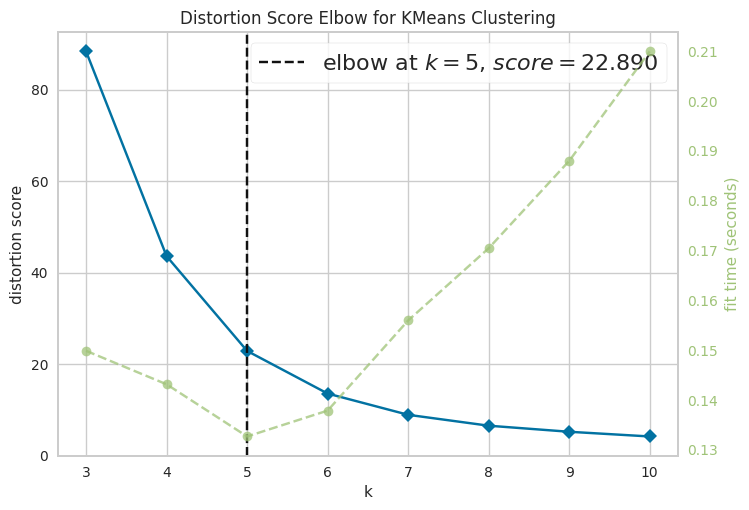

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1112]:
# Select number of clusters using "elbow" heuristic and distortion score

k_range = range(3, 11)
kmeans = KMeans(n_init=100, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=k_range)

visualizer.fit(embeddings)

best_k = visualizer.elbow_value_
visualizer.show()

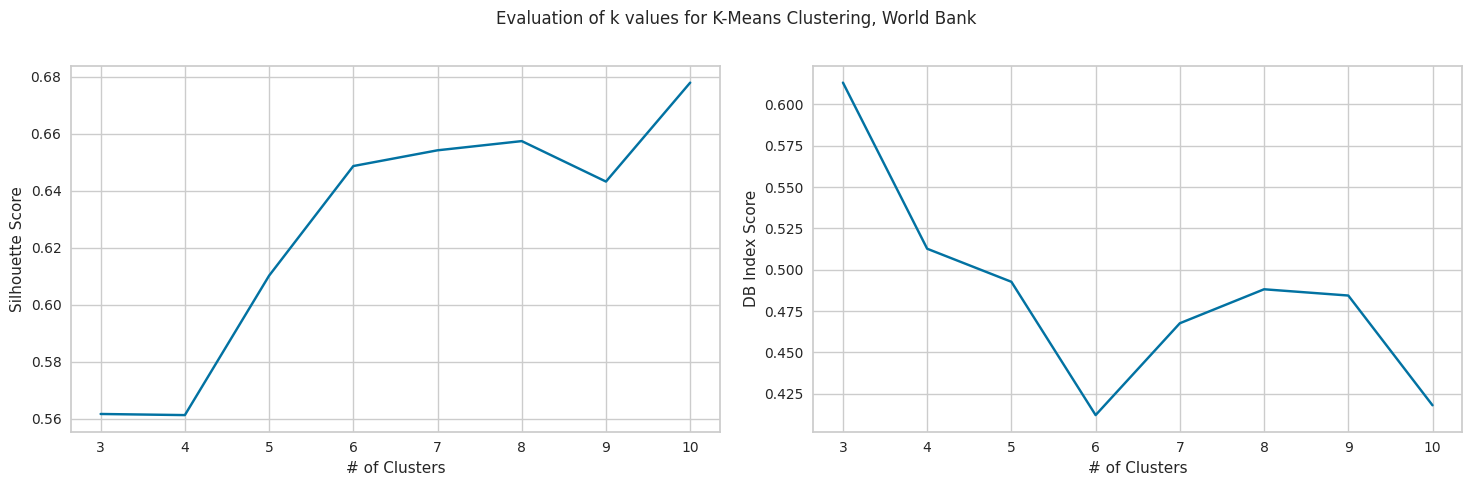

In [1113]:
# Evaluation score of each k value
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

score_s = []
score_db = []
score_ch = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
    kmeans.fit(embeddings)
    score_s.append(silhouette_score(embeddings, kmeans.labels_))
    score_db.append(davies_bouldin_score(embeddings, kmeans.labels_))
    score_ch.append(calinski_harabasz_score(embeddings, kmeans.labels_))

# Produce silhouette plot
ax1.plot((k_range), score_s)
ax1.set_xlabel("# of Clusters")
ax1.set_ylabel("Silhouette Score")
# ax1.grid(False)

ax2.plot((k_range), score_db)
ax2.set_xlabel("# of Clusters")
ax2.set_ylabel("DB Index Score")
# ax2.grid(False)

# ax3.plot((k_range), score_ch)
# ax3.set_xlabel("# of Clusters")
# ax3.set_ylabel("C-H Index Score")
# ax3.grid(False)

fig.suptitle(
    "Evaluation of k values for K-Means Clustering, {}".format(params["dataset"]),
    fontsize=12,
)
plt.tight_layout()
plt.show()

In [1114]:
# Override best k from Elbow Method
best_k = 6 if not OECD else best_k

In [1115]:
# Get scores of best k value
kmeans = KMeans(n_clusters=best_k, n_init=100, random_state=42)
kmeans.fit(embeddings)
print_scores(embeddings, kmeans.labels_)

Silhouette: 0.649, DB_index: 0.412


In [1116]:
# Save best labels
best_labels = kmeans.labels_

### Cluster Visualization

In [1117]:
# Visualize the clusters on UMAP projection and world map
params["method"] = "K-Means"
params["scale"] = None
viz_reduction(add_info_to_reduced(embeddings, df, best_labels), params) | world_map(
    kmeans.labels_, params
)

alt.HConcatChart(...)

## Alternative Methods - Agglomerative Clustering

In [1118]:
# Cluster size is selected based on number of clusters that appear visually on UMAP projection
agg = AgglomerativeClustering(n_clusters=(4 if not OECD else 5))
agg.fit(embeddings)

print_scores(embeddings, agg.labels_)

Silhouette: 0.607, DB_index: 0.461


In [1119]:
# Visualize the clusters on UMAP projection and world map
params["method"] = "Agglomerative"
params["scale"] = None
viz_reduction(add_info_to_reduced(embeddings, df, agg.labels_), params) | world_map(
    agg.labels_, params
)

alt.HConcatChart(...)

## Sensitivity Analysis

Sensitivity Analysis Part 1: Re-running K-means clustering without UMAP dimensionality reduction

Goals: 
- Test if optimal number of clusters found is same or different
- Check similarity between distribution of clusters with and without UMAP

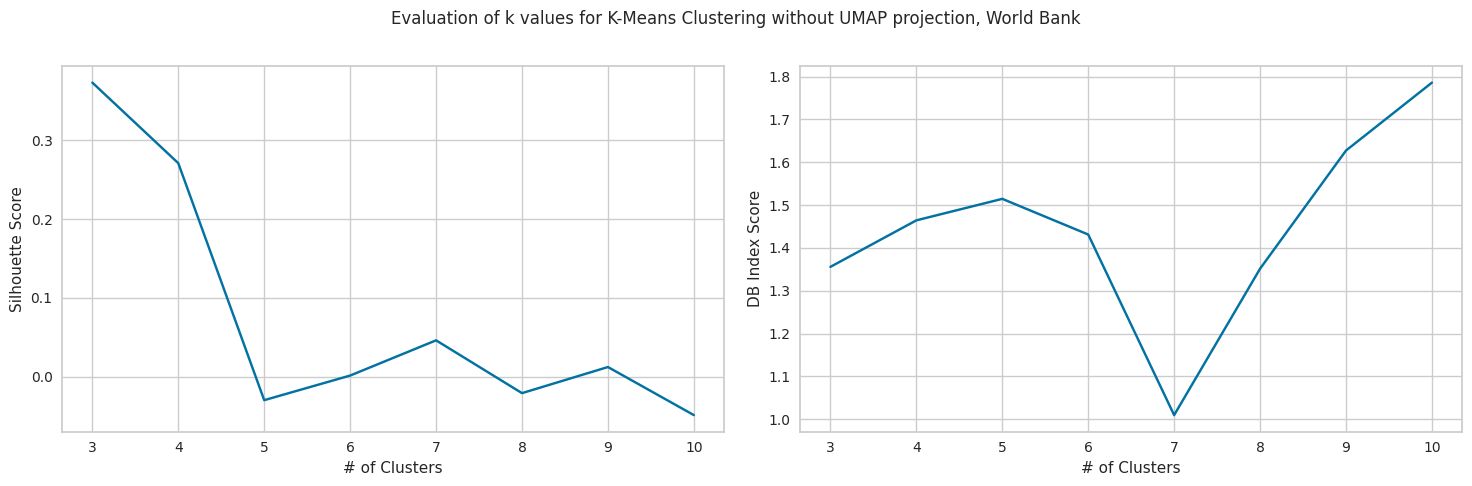

In [1120]:
# Sensitivity Eval
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

score_s = []
score_db = []
score_ch = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
    kmeans.fit(X)
    score_s.append(silhouette_score(embeddings, kmeans.labels_))
    score_db.append(davies_bouldin_score(embeddings, kmeans.labels_))
    score_ch.append(calinski_harabasz_score(embeddings, kmeans.labels_))

# Produce plots
ax1.plot((k_range), score_s)
ax1.set_xlabel("# of Clusters")
ax1.set_ylabel("Silhouette Score")
# ax1.grid(False)

ax2.plot((k_range), score_db)
ax2.set_xlabel("# of Clusters")
ax2.set_ylabel("DB Index Score")
# ax2.grid(False)

fig.suptitle(
    "Evaluation of k values for K-Means Clustering without UMAP projection, {}".format(
        params["dataset"]
    ),
    fontsize=12,
)
plt.tight_layout()

In [1121]:
# Visualize the clusters on world map
best_k_no_umap = score_db.index(min(score_db)) + k_range[0]
kmeans = KMeans(n_clusters=best_k_no_umap, n_init=100, random_state=42)
kmeans.fit(X)

params["method"] = "K-Means (Without UMAP)"
world_map(kmeans.labels_, params)

alt.LayerChart(...)

Sensitivity Analysis Part 2: Testing effect of different year selection on metrics, holding K constant

/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden

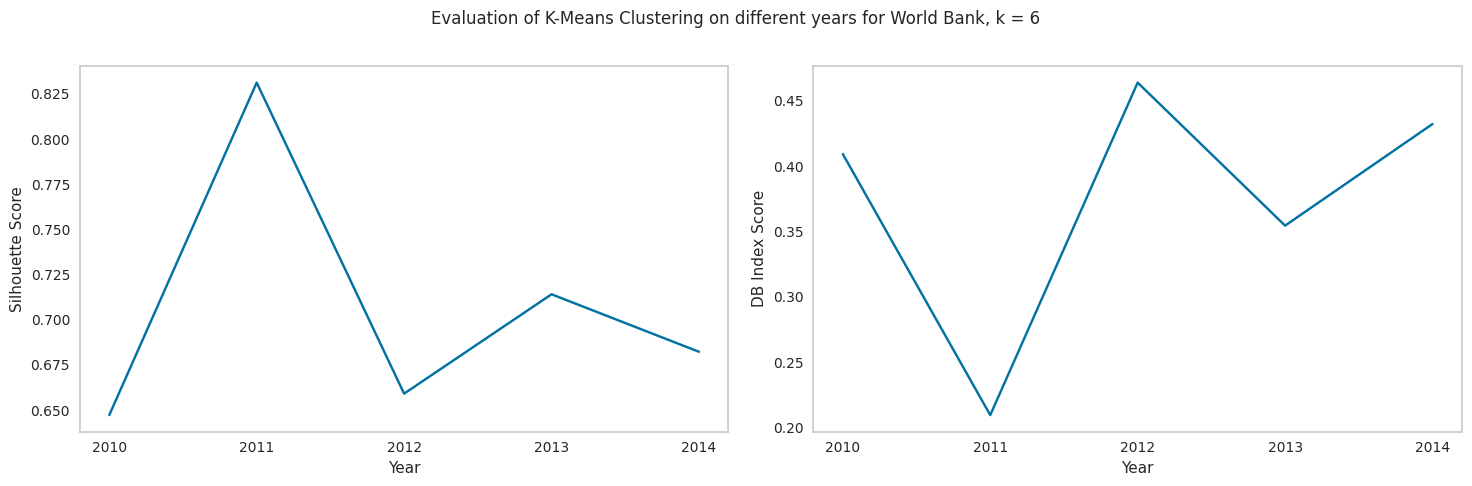

In [1122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

score_s = []
score_db = []

year_range = range(2010, 2015)

for year in year_range:
    temp_X = original_df.copy()
    temp_X = temp_X[temp_X["Year"] == year]
    temp_X = temp_X.drop(columns=["Country", "Year", mm_ind])

    temp_embeddings = umap.UMAP(
        n_components=2,
        n_neighbors=3,
        min_dist=(0 if not OECD else 0.1),
        random_state=42,
    ).fit_transform(temp_X)

    kmeans = KMeans(n_clusters=best_k, n_init=100, random_state=42)
    kmeans.fit(temp_embeddings)

    score_s.append(silhouette_score(temp_embeddings, kmeans.labels_))
    score_db.append(davies_bouldin_score(temp_embeddings, kmeans.labels_))

# Produce silhouette plot
ax1.plot((year_range), score_s)
ax1.set_xlabel("Year")
ax1.set_ylabel("Silhouette Score")
ax1.set_xticks(year_range)
ax1.grid(False)

ax2.plot((year_range), score_db)
ax2.set_xlabel("Year")
ax2.set_ylabel("DB Index Score")
ax2.set_xticks(year_range)
ax2.grid(False)

fig.suptitle(
    "Evaluation of K-Means Clustering on different years for {}, k = {}".format(
        params["dataset"], best_k
    ),
    fontsize=12,
)
plt.tight_layout()

## Investigation of Cluster Groups

In [1123]:
# Investigating stats of MMR for each cluster group
df["Cluster"] = best_labels
df.groupby("Cluster")[mm_ind].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,11.0,3.454545,3.173756,0.0,0.50,3.0,5.00,9.0
1,7.0,13.000000,20.000000,0.0,2.50,5.0,12.00,57.0
2,4.0,29.000000,14.306176,17.0,17.75,26.0,37.25,47.0
3,6.0,4.666667,2.160247,2.0,2.75,5.5,6.00,7.0
4,8.0,5.250000,4.464143,0.0,3.00,4.0,6.25,15.0
5,5.0,2.000000,1.414214,0.0,1.00,3.0,3.00,3.0
